In [1]:
# Mount the Google drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


- [1.Data Processing](#1.-data-processing)
- [2.Modeling Process](#2.-modeling-process)
- [3.Adversarial Attack](#3.-adversarial-attack)
- [4.Report](#4.-report)

In [2]:
import torch


In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [4]:
# install ART library, which provide adversarial attack
!pip install adversarial-robustness-toolbox

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 14.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 30.5/30.5 MB 46.5 MB/s eta 0:00:00
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.2.2
    Uninstalling scikit-learn-1.2.2:
      Successfully uninstalled scikit-learn-1.2.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
bigframes 0.19.2 requires scikit-learn>=1.2.2, but you have scikit-learn 1.1.3 which is incompatible.


In [5]:
# import libraries

import tensorflow as tf
import keras

import numpy as np
import matplotlib.pyplot as plt
import os
from os import listdir
import cv2
import natsort
import scipy.io
from sklearn.model_selection import train_test_split

# this line makes ART toolbox work. Run this line before training the model
tf.compat.v1.disable_eager_execution()

print("Tensorflow version: ", tf.__version__)

Tensorflow version:  2.15.0


## 1. Data Processing<a name= '1.-data-processing'></a>

In [7]:
# create a directory to save dataset
os.makedirs('sample_data/oxford_flowers', exist_ok=True)

In [8]:
# download dataset

!wget http://www.robots.ox.ac.uk/~vgg/data/flowers/102/102flowers.tgz

--2024-01-27 16:08:20--  http://www.robots.ox.ac.uk/~vgg/data/flowers/102/102flowers.tgz
Resolving www.robots.ox.ac.uk (www.robots.ox.ac.uk)... 129.67.94.2
Connecting to www.robots.ox.ac.uk (www.robots.ox.ac.uk)|129.67.94.2|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://www.robots.ox.ac.uk/~vgg/data/flowers/102/102flowers.tgz [following]
--2024-01-27 16:08:20--  https://www.robots.ox.ac.uk/~vgg/data/flowers/102/102flowers.tgz
Connecting to www.robots.ox.ac.uk (www.robots.ox.ac.uk)|129.67.94.2|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://thor.robots.ox.ac.uk/datasets/flowers-102/102flowers.tgz [following]
--2024-01-27 16:08:20--  https://thor.robots.ox.ac.uk/datasets/flowers-102/102flowers.tgz
Resolving thor.robots.ox.ac.uk (thor.robots.ox.ac.uk)... 129.67.95.98
Connecting to thor.robots.ox.ac.uk (thor.robots.ox.ac.uk)|129.67.95.98|:443... connected.
HTTP request sent, awaiting respo

In [9]:
# uncompress the dataset
!tar -zxvf 102flowers.tgz -C 'sample_data/oxford_flowers' > /dev/null 2>&1

In [10]:
# define a funtion to load the images

def load_images(root):
    imgs_list = [] # to store the image value

    image_files_list = listdir(root) # image file list
    image_files_list_sorted = natsort.natsorted(image_files_list)

    for i in range(len(image_files_list_sorted)):
        # read the image
        img_temp = cv2.imread(os.path.join(root,image_files_list_sorted[i]))
        # resize the image
        img_resized = cv2.resize(img_temp, (128, 128))
        # normalized the image value
        imgs_list.append(img_resized/255)

    # convert image values list to numpy array
    imgs = np.asarray(imgs_list)

    return imgs
images = load_images('sample_data/oxford_flowers/jpg')

In [11]:
# check the shape of the images
images.shape

(8189, 128, 128, 3)

In [12]:
# download the file with the labels
!wget http://www.robots.ox.ac.uk/~vgg/data/flowers/102/imagelabels.mat

URL transformed to HTTPS due to an HSTS policy
--2024-01-27 16:09:25--  https://www.robots.ox.ac.uk/~vgg/data/flowers/102/imagelabels.mat
Resolving www.robots.ox.ac.uk (www.robots.ox.ac.uk)... 129.67.94.2
Connecting to www.robots.ox.ac.uk (www.robots.ox.ac.uk)|129.67.94.2|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://thor.robots.ox.ac.uk/datasets/flowers-102/imagelabels.mat [following]
--2024-01-27 16:09:25--  https://thor.robots.ox.ac.uk/datasets/flowers-102/imagelabels.mat
Resolving thor.robots.ox.ac.uk (thor.robots.ox.ac.uk)... 129.67.95.98
Connecting to thor.robots.ox.ac.uk (thor.robots.ox.ac.uk)|129.67.95.98|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 502 [application/octet-stream]
Saving to: ‘imagelabels.mat’

imagelabels.mat     100%[===================>]     502  --.-KB/s    in 0s      

2024-01-27 16:09:25 (212 MB/s) - ‘imagelabels.mat’ saved [502/502]



In [13]:
# load the labels from the file
labels_data = scipy.io.loadmat('imagelabels.mat')
labels = np.squeeze(labels_data['labels']) - 1
print(labels)
print(labels.shape)

[76 76 76 ... 61 61 61]
(8189,)


In [14]:
# split the dataset into train dataset and test dataset

train_images, test_images, train_labels, test_labels = train_test_split(images, labels,
                                                                   test_size = 0.15,
                                                                   stratify = labels,
                                                                   random_state = 123)

In [15]:
# display the shape of train and test datasets

print('images train shape: {} - labels train shape: {}'.format(train_images.shape, train_labels.shape))
print('images test shape: {} - labels test shape: {}'.format(test_images.shape, test_labels.shape))

# display the range of images to make sure their values are in range [0,1]
print('\nMax pixel value: ', np.max(train_images))
print('Min pixel value: ', np.min(train_images))
print('Average pixel value: ', np.average(train_images))
print('Data type: ', train_images[0].dtype)

images train shape: (6960, 128, 128, 3) - labels train shape: (6960,)
images test shape: (1229, 128, 128, 3) - labels test shape: (1229,)

Max pixel value:  1.0
Min pixel value:  0.0
Average pixel value:  0.3665724855138819
Data type:  float64


In [16]:
# Split the dataset into train and test sets
train_images, test_images, train_labels, test_labels = train_test_split(images, labels, test_size=0.15, random_state=12)

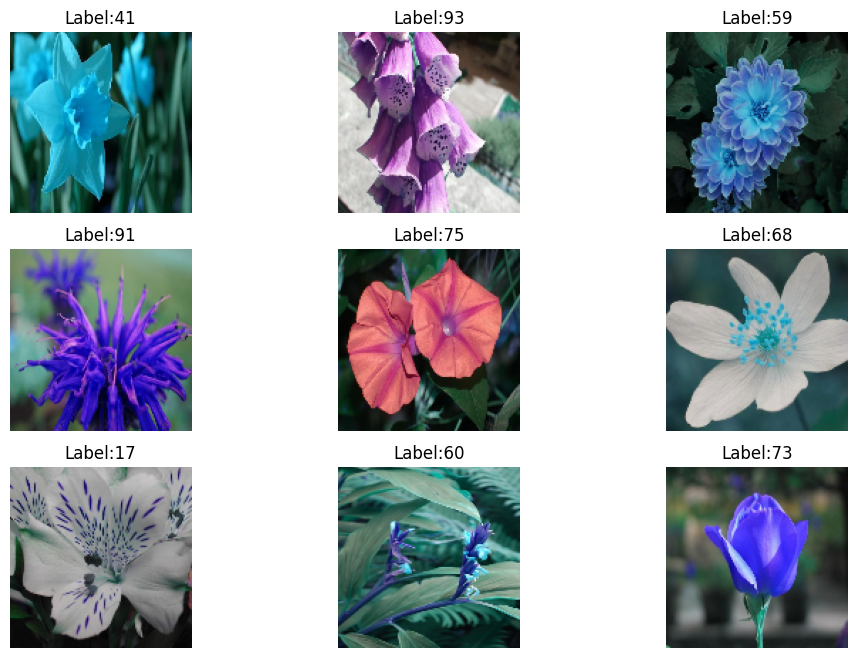

In [17]:
# plot some images and its labels

plt.figure(figsize=(12,8))
for i in range(9):
    plt.subplot(3, 3, i+1)
    index = np.random.randint(0,(len(train_images)),1)
    plt.imshow(train_images[index[0]])
    plt.title('Label:'+str(train_labels[index[0]]))
    plt.axis('off')

In [18]:
# Asscociate the labels and names of flowers
flower_names = {"21": "fire lily", "3": "canterbury bells", "45": "bolero deep blue", "1": "pink primrose", "34": "mexican aster", "27": "prince of wales feathers", "7": "moon orchid", "16": "globe-flower", "25": "grape hyacinth", "26": "corn poppy", "79": "toad lily", "39": "siam tulip", "24": "red ginger", "67": "spring crocus", "35": "alpine sea holly", "32": "garden phlox", "10": "globe thistle", "6": "tiger lily", "93": "ball moss", "33": "love in the mist", "9": "monkshood", "102": "blackberry lily", "14": "spear thistle", "19": "balloon flower", "100": "blanket flower", "13": "king protea", "49": "oxeye daisy", "15": "yellow iris", "61": "cautleya spicata", "31": "carnation", "64": "silverbush", "68": "bearded iris", "63": "black-eyed susan", "69": "windflower", "62": "japanese anemone", "20": "giant white arum lily", "38": "great masterwort", "4": "sweet pea", "86": "tree mallow", "101": "trumpet creeper", "42": "daffodil", "22": "pincushion flower", "2": "hard-leaved pocket orchid", "54": "sunflower", "66": "osteospermum", "70": "tree poppy", "85": "desert-rose", "99": "bromelia", "87": "magnolia", "5": "english marigold", "92": "bee balm", "28": "stemless gentian", "97": "mallow", "57": "gaura", "40": "lenten rose", "47": "marigold", "59": "orange dahlia", "48": "buttercup", "55": "pelargonium", "36": "ruby-lipped cattleya", "91": "hippeastrum", "29": "artichoke", "71": "gazania", "90": "canna lily", "18": "peruvian lily", "98": "mexican petunia", "8": "bird of paradise", "30": "sweet william", "17": "purple coneflower", "52": "wild pansy", "84": "columbine", "12": "colt's foot", "11": "snapdragon", "96": "camellia", "23": "fritillary", "50": "common dandelion", "44": "poinsettia", "53": "primula", "72": "azalea", "65": "californian poppy", "80": "anthurium", "76": "morning glory", "37": "cape flower", "56": "bishop of llandaff", "60": "pink-yellow dahlia", "82": "clematis", "58": "geranium", "75": "thorn apple", "41": "barbeton daisy", "95": "bougainvillea", "43": "sword lily", "83": "hibiscus", "78": "lotus lotus", "88": "cyclamen", "94": "foxglove", "81": "frangipani", "74": "rose", "89": "watercress", "73": "water lily", "46": "wallflower", "77": "passion flower", "51": "petunia"}

In [19]:
len(flower_names.keys())

102

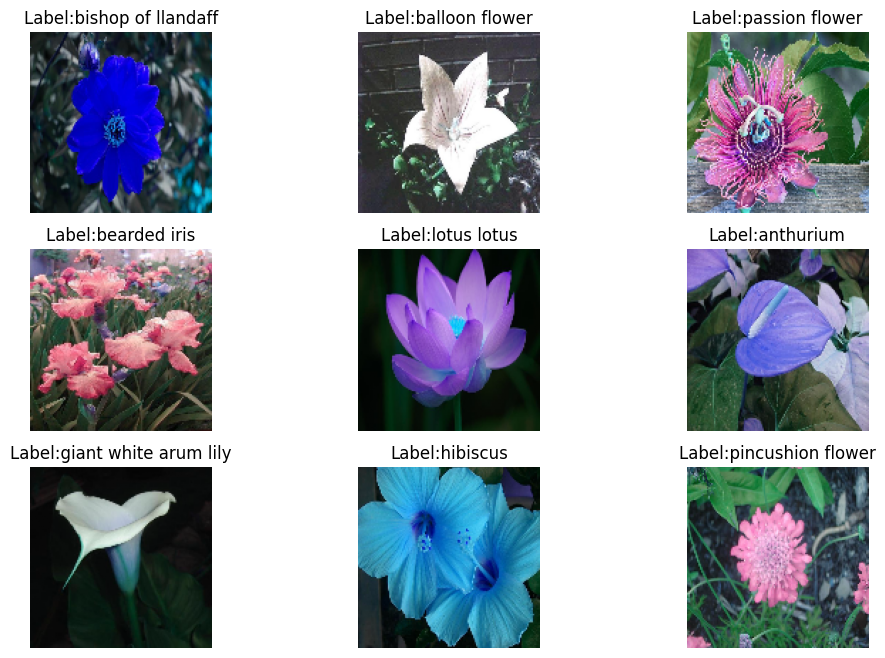

In [20]:
# plot a few images and the flower name
plt.figure(figsize=(12,8))

for i in range(9):
    plt.subplot(3, 3, i+1)
    index = np.random.randint(1, len(train_images), 1)
    plt.imshow(train_images[index[0]])
    plt.title("Label:"+ flower_names[str(train_labels[index[0]]+1)])
    plt.axis('off')

## 2. Modeling Process<a name = '2.-modeling-process'></a>

In [21]:
from keras.models import Model
from keras.layers import Dense, GlobalAveragePooling2D, Dropout
from keras.optimizers.legacy import Adam
from keras.callbacks import EarlyStopping
from keras.applications import vgg16

import datetime
now = datetime.datetime.now

In [22]:
# define the base model
base_model = vgg16.VGG16(weights='imagenet', include_top=False, input_shape=(128,128,3))

# add global spatial average pooling layer
x = base_model.output
x = GlobalAveragePooling2D()(x)

# add fully-connected layers
x = Dense(units=2048, activation='relu')(x)
x = Dropout(rate=0.25)(x)
x = Dense(units=512, activation='relu')(x)
x = Dropout(rate=0.25)(x)
predictions = Dense(units=102, activation='softmax')(x)

model_krs = Model(inputs=base_model.input, outputs=predictions)

58889256/58889256 [==============================] - 2s 0us/step


In [23]:
# compile the model
model_krs.compile(optimizer=tf.keras.optimizers.legacy.Adam(learning_rate=1e-4), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
callbacks_krs = [EarlyStopping(monitor='val_loss', patience=10)]

In [24]:
# train the model
t1 = now()
history_krs = model_krs.fit(train_images, train_labels, batch_size=64, epochs=100, validation_split=0.2, verbose=1, callbacks=callbacks_krs)

print(f'model training time: {now() - t1}')

Train on 5568 samples, validate on 1392 samples
Epoch 1/100
5568/5568 [==============================] - ETA: 0s - loss: 4.5228 - accuracy: 0.0325

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training_v1.py:2335: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates


5568/5568 [==============================] - 51s 9ms/sample - loss: 4.5228 - accuracy: 0.0325 - val_loss: 4.1459 - val_accuracy: 0.0984
Epoch 2/100
5568/5568 [==============================] - 24s 4ms/sample - loss: 3.8133 - accuracy: 0.1329 - val_loss: 3.0962 - val_accuracy: 0.2658
Epoch 3/100
5568/5568 [==============================] - 25s 4ms/sample - loss: 2.8403 - accuracy: 0.3035 - val_loss: 2.2888 - val_accuracy: 0.4339
Epoch 4/100
5568/5568 [==============================] - 25s 4ms/sample - loss: 1.9781 - accuracy: 0.4768 - val_loss: 1.7294 - val_accuracy: 0.5438
Epoch 5/100
5568/5568 [==============================] - 25s 5ms/sample - loss: 1.4292 - accuracy: 0.6105 - val_loss: 1.2719 - val_accuracy: 0.6466
Epoch 6/100
5568/5568 [==============================] - 25s 5ms/sample - loss: 0.9804 - accuracy: 0.7229 - val_loss: 1.1459 - val_accuracy: 0.6925
Epoch 7/100
5568/5568 [==============================] - 25s 4ms/sample - loss: 0.7829 - accuracy: 0.7750 - val_loss: 0.8318

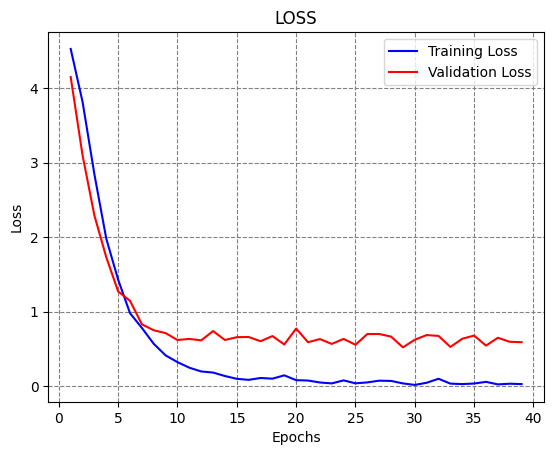

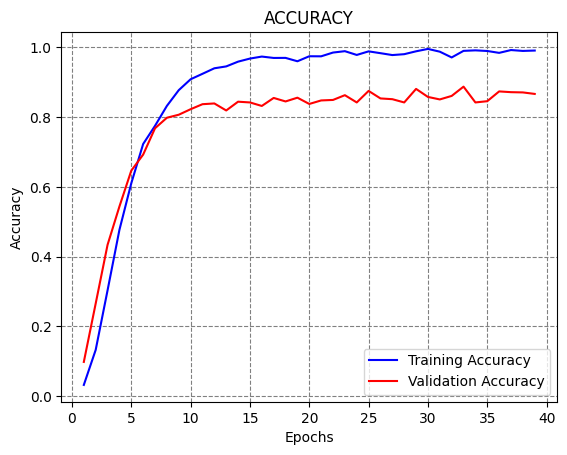

In [25]:
# Plot the loss and accuracy
train_loss = history_krs.history['loss']
val_loss = history_krs.history['val_loss']
acc = history_krs.history['accuracy']
val_acc = history_krs.history['val_accuracy']

epochsn = np.arange(1, len(train_loss)+1,1)
plt.plot(epochsn,train_loss, 'b', label='Training Loss')
plt.plot(epochsn,val_loss, 'r', label='Validation Loss')
plt.grid(color='gray', linestyle='--')
plt.legend()
plt.title('LOSS')
plt.xlabel('Epochs')
plt.ylabel('Loss')

plt.figure()
plt.plot(epochsn, acc, 'b', label='Training Accuracy')
plt.plot(epochsn, val_acc, 'r', label='Validation Accuracy')
plt.grid(color='gray', linestyle='--')
plt.legend()
plt.title('ACCURACY')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.show()

In [26]:
test_accuracy = model_krs.evaluate(test_images, test_labels)
print(f'Test Accuracy: {test_accuracy[1]:5.4f}')

Test Accuracy: 0.8779


## 3. Adversial Attacks (Fast Gradient Sing Method and Projected Gradient Descent)<a name='3.-adversarial-attack'></a>

In [27]:
from art.estimators.classification import KerasClassifier
from art.attacks.evasion import FastGradientMethod, ProjectedGradientDescent

In [28]:
# create keras classifier
classifier = KerasClassifier(model=model_krs, clip_values=(0, 1), use_logits=True)


/usr/local/lib/python3.10/dist-packages/keras/src/backend.py:5727: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


In [29]:
# use the first 200 test images to create adversarial images
adv_images = test_images[0:200]
adv_labels = test_labels[0:200]

In [30]:
# Fast Gradient Sign Method

epsilon= [0./255, 1/255, 3/255, 5/255, 8/255, 20/255, 50/255, 80/255]

fgsm_attack_acc = []

for eps in epsilon:

    #create fgsm object
    attack_fgsm = FastGradientMethod(estimator=classifier, eps=eps)

    #create adversarial images
    images_fgsm_att = attack_fgsm.generate(adv_images)

    #use previous trained model to evaluate on adversarial images
    loss_fgsm_att, accuracy_fgsm_att = model_krs.evaluate(images_fgsm_att, adv_labels)

    #add the accuracy to fgsm list
    fgsm_attack_acc.append(accuracy_fgsm_att)

print(fgsm_attack_acc)

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training_v1.py:2359: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


[0.86, 0.75, 0.415, 0.285, 0.225, 0.155, 0.055, 0.035]


In [31]:
# Projected Gradient Descent

pgd_attack_acc = []

for eps in epsilon:
    # create an Project Gradient Descent object
    attack_pgd = ProjectedGradientDescent(estimator=classifier, eps=eps)

    # create pgd attacked images
    images_pgd_att = attack_pgd.generate(adv_images)

    # use previously train model to evaluate the pgd attacked images
    loss_pgd_att, accuracy_pgd_att = model_krs.evaluate(images_pgd_att, adv_labels)

    # append accuracy_pgd_att to pgd_attack_acc list
    pgd_attack_acc.append(accuracy_pgd_att)

print(pgd_attack_acc)


PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

[0.86, 0.71, 0.3, 0.165, 0.13, 0.06, 0.045, 0.045]


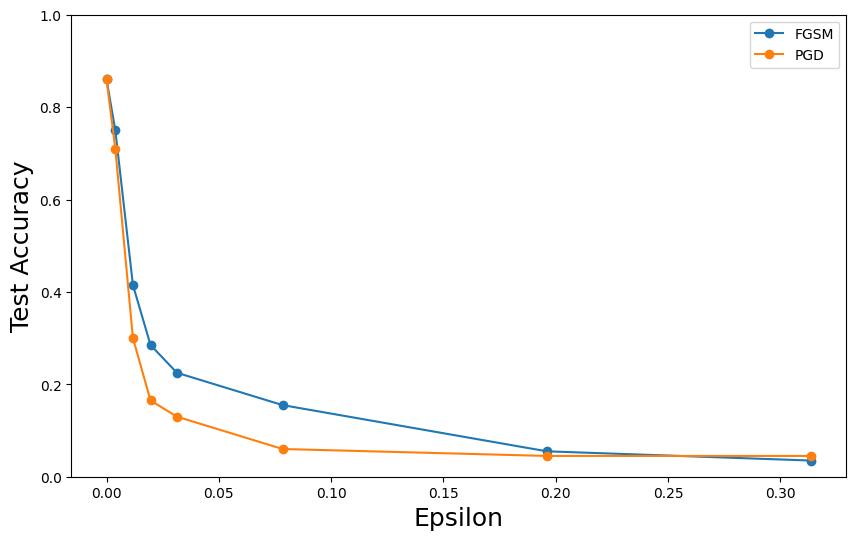

In [32]:
# plot the test accuracy of FGSM and PGD

attack_name = ['FGSM', 'PGD']
attack_acc = [fgsm_attack_acc, pgd_attack_acc]

plt.figure(figsize=(10,6))
plt.ylim(0,1)
plt.xlabel('Epsilon', fontsize=18)
plt.ylabel('Test Accuracy', fontsize=18)

for i in range(len(attack_name)):
    plt.plot(epsilon, attack_acc[i], marker='o', label=attack_name[i])

plt.legend(loc='upper right')
plt.show()

Perturbation maginutude: 0.0118
Predicted Label:  water lily


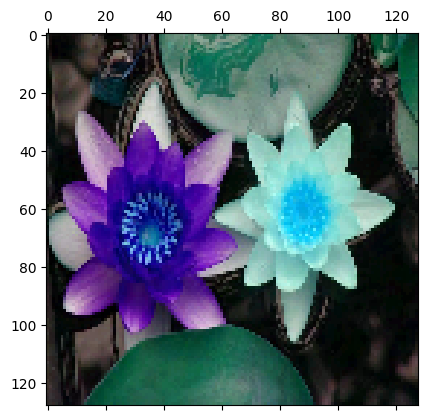

Perturbation maginutude: 0.0314
Predicted Label:  water lily


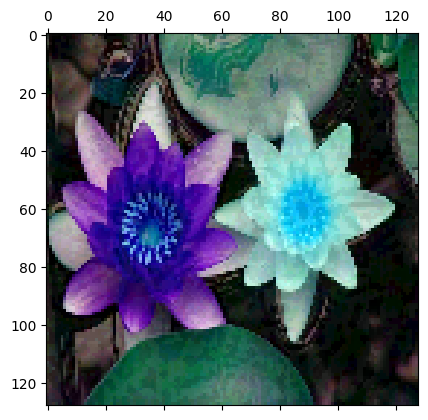

Perturbation maginutude: 0.0784
Predicted Label:  peruvian lily


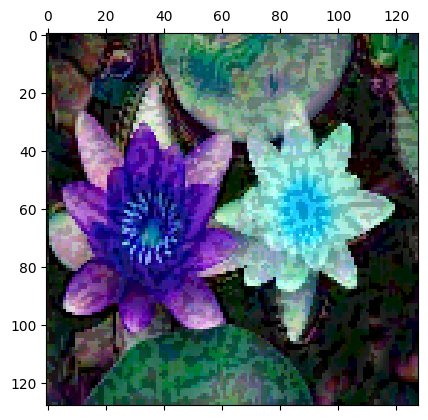

Perturbation maginutude: 0.1961
Predicted Label:  peruvian lily


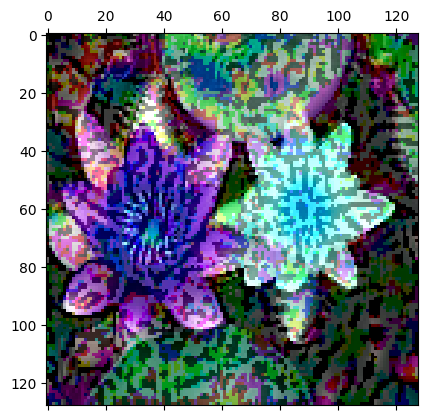

Perturbation maginutude: 0.3137
Predicted Label:  peruvian lily


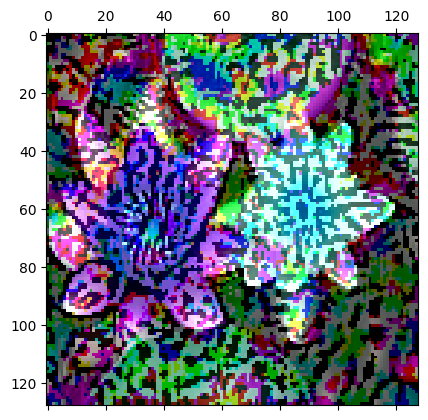

In [33]:
# plot figures of fgsm attack on first test iamge with different epsilon
epsilon_1 = [3/255, 8/255, 20/255, 50/255, 80/255]

for eps in epsilon_1:

    # create fgsm attack object
    fgsm_attack = FastGradientMethod(estimator=classifier, eps=eps)

    # creat adversarail images
    image_1_fgsm = fgsm_attack.generate(adv_images[0:1])

    print('Perturbation maginutude: {:5.4f}'.format(eps))
    # predicted the label of the attacked image
    preds = model_krs.predict(image_1_fgsm)

    # print the label
    print('Predicted Label: ', flower_names[str(np.argmax(preds[0], axis=-1)+1)])

    # plot the attacked image
    plt.matshow(np.squeeze(image_1_fgsm[0]))
    plt.show()





## 4. Report<a name='4.-report'></a>

**Table1:** Classification Accuracy

| **model** | train set | validataion set | test set |
|-----------|-----------|-----------------|----------|
|fine tune VGG16 model with Keras| 0.9907 | 0.8664   | 0.8779|

**Table 2:** Classification accuracy on clean and adversarial images

|  model  | clean images | adversarial images(1/255) | avdersarial images(5/255) | adversarial images (8/255)|
|---------|--------------|---------------------------|---------------------------|---------------------------|
|FGSM attack|   0.86     |   0.75                    |  0.285                    | 0.225                     |
|PGD attack |   0.86     |   0.71                    |  0.165                    | 0.13                      |

**Analysis**

Adversarial pertubation has a significant impact on model accuracy, even we add some pertutaion to the originial data, the classification accuracy declines dramatically. But it also shows PGD attack has more impact than FGSM attack. Especially when purtubation increasing, the impact is also increasing. 